##**Notes/reminders:**

* Clinical data has been excluded
(because they will still be extracted from the medical records, classifying the oligosymptomatic patients separately, allowing a better evaluation of the machine)

* Version used in the code below: 
- Python version: 3.11.7
- scikit-learn version: 1.2.2
- imbalanced-learn version: 0.12.1
- scikit-optimize version: 0.10.1

* It uses only one machine-learning evaluation model, several of which will be used in the final master's work. The current script corresponds to a training script developed in conjunction with pacific (more complex).

## Dictionary:
* In column: SEX
 * M = 0
 * F = 1

* In column: Provavel_HAM/TSP
* No symptomps associated to HAM/TSP = 0
* In presence of Spasticity or Hypereflexia in the lower limbs or Neurogenic bladder = 1

* rs10748643: 
    - GG = 0
    - AG = 1
    - AA = 2

* rs11188513
    - TT = 0
    - CT = 1
    - CC = 2

# **Loading data and packages**

**Libraries import**

In [2]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
import ipywidgets as widgets
from ipywidgets import interact
from sklearn.datasets import make_classification
from sklearn.model_selection import (
    train_test_split, RepeatedStratifiedKFold, LeaveOneOut, cross_validate
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (
    ExtraTreesClassifier, RandomForestClassifier,
    AdaBoostClassifier, GradientBoostingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    make_scorer, confusion_matrix, classification_report, roc_curve, auc, balanced_accuracy_score
)
from imblearn.over_sampling import SMOTENC, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.metrics import geometric_mean_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from joblib import dump, load
from scipy.stats import skew, kurtosis, ttest_ind

# Ignoring warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact

import os
import statsmodels.api as sm
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



# Data selection
clinic_dataset = '../datasets/df_clinic_ENTPD1.csv'
hemogram_dataset = '../datasets/df_hemogram_ENTPD1.csv'
clinic_dataset_cat1 = '../datasets/cat1_df_clinic_ENTPD1.csv'
hemogram_dataset_cat1 = '../datasets/df_hemogram_cat_1.csv'
clinic_dataset_cat2 = '../datasets/cat2_df_clinic_ENTPD1.csv'
hemogram_dataset_cat2 = '../datasets/cat2_df_hemogram_ENTDP1.csv'


In [3]:
# Defining global variables to store the DataFrame
df = pd.DataFrame()
dataset_name = None  

# Function to load and process the selected dataset
def load_and_process_data(selected_data):
    global df, dataset_name  
    dataset_name = selected_data  
    
    if selected_data == 'Clinical data':
        df = pd.read_table(clinic_dataset_cat1, sep=',')
        df['Gênero'] = df['Gênero'].replace('M', 0)
        df['Gênero'] = df['Gênero'].replace('F', 1)
        columns_to_drop = ['Espasticidade', 'Neuropatia MMSS', 'Bexiga Neurogênica', 'Código', 'Prontuário']
        df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

    elif selected_data == 'Clinic dataset cat 1':
        df = pd.read_table(clinic_dataset_cat1, sep=',')
        df['Gênero'] = df['Gênero'].replace('M', 0)
        df['Gênero'] = df['Gênero'].replace('F', 1)
        columns_to_drop = ['Código', 'Prontuário']
        df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1)

    elif selected_data == 'Clinic dataset cat 2':
        df = pd.read_table(clinic_dataset_cat2, sep=',')
        df['Gênero'] = df['Gênero'].replace('M', 0)
        df['Gênero'] = df['Gênero'].replace('F', 1)
        columns_to_drop = ['Código', 'Prontuário']
        df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1)


    elif selected_data == 'Hemogram data':
        df = pd.read_table(hemogram_dataset, sep=',')
        df.rename(columns={'Provável HAM/TSP':'PROVAVEL_HAM/TSP' }, inplace=True)
        df['Gênero'] = df['Gênero'].replace('M', 0)
        df['Gênero'] = df['Gênero'].replace('F', 1)
        columns_to_drop = ['Blastos', 'Promielocitos', 'Mielocitos', 'Metamielocitos', 'Bastonetes', 
                         'Linfocitos Atipicos', 'Eritroblastos', 'HAM/TSP', 'Código']
        df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)
        df.rename(columns={'Ano_hemograma':'Idade_clinica'}, inplace=True)
        for col in df.select_dtypes(include=['object']).columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        # Normalization with MinMaxScaler, except for the specified columns
        cols_to_normalize = df.columns.difference(['PROVAVEL_HAM/TSP', 'Gênero', 'rs10748643', 'rs11188513'])
        scaler = MinMaxScaler()
        df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])
        print(f"Data Loaded and Processed Successfully! Dataset: {dataset_name}")

    elif selected_data == 'Hemogram data cat 1':
        df = pd.read_table(hemogram_dataset_cat1, sep=',')

        # Normalization with MinMaxScaler, except for the specified columns
        for col in df.select_dtypes(include=['object']).columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
       
        print(f"Data Loaded and Processed Successfully! Dataset: {dataset_name}")

    elif selected_data == 'Hemogram data cat 2':
        df = pd.read_table(hemogram_dataset_cat2, sep=',')
        columns_to_drop = ['rs10748643', 'rs11188513']
        df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)
        # Normalization with MinMaxScaler, except for the specified columns
        for col in df.select_dtypes(include=['object']).columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
       
        print(f"Data Loaded and Processed Successfully! Dataset: {dataset_name}")
    else:
        df = pd.DataFrame()

    return df.head()

# List of dataset options
data_options = ['Clinical data', 'Hemogram data', 'Clinic dataset cat 1', 'Hemogram data cat 1', 'Clinic dataset cat 2', 'Hemogram data cat 2']

# Selection widget to choose the dataset
data_selector = widgets.Dropdown(
    options=data_options,
    description='Select Data:'
)

# Interactive function to load and process the selected dataset
@interact(selected_data=data_selector)
def load_and_process_selected_data(selected_data):
    return load_and_process_data(selected_data)



interactive(children=(Dropdown(description='Select Data:', options=('Clinical data', 'Hemogram data', 'Clinic …

In [33]:
print(df.columns)

Index(['Gênero', 'Idade_clinica', 'PROVAVEL_HAM/TSP',
       'Expression_CD39_Diplotypes', 'PCA_Hemacias', 'PCA_Leucocitos',
       'PCA_Plaquetas'],
      dtype='object')


# **Exploratory analysis**


**Target frequency distribution (HAM/TSP)**

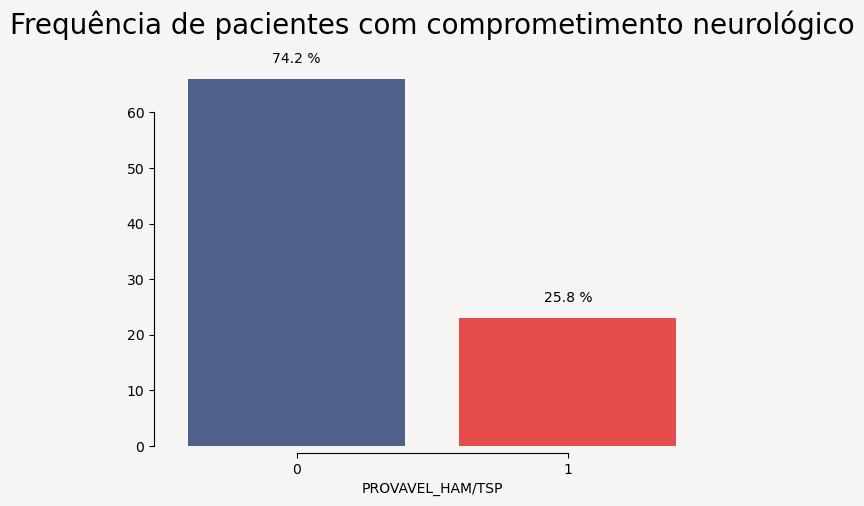

In [25]:
# Color palette
mypal = ['#465d91', '#FFFFE0', '#FF3232']

# Bar Graph for Distribution of Variables
plt.figure(figsize=(7, 5), facecolor='#F6F5F4')
total = float(len(df))
ax = sns.countplot(x=df['PROVAVEL_HAM/TSP'], palette=mypal[0::2])
ax.set_facecolor('#F6F5F4')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, '{:1.1f} %'.format((height / total) * 100), ha="center")

ax.set_title('Frequência de pacientes com comprometimento neurológico', fontsize=20, y=1.05)
ax.set_ylabel('')
sns.despine(right=True)
sns.despine(offset=5, trim=True)

# Save the graphic in JPEG
plt.savefig('../exploratory_analysis/Frequência_HAM_TSP.jpeg')

# Show the graphic
plt.show()

**Pearson correlation matrix initial dataset (heatmap):**

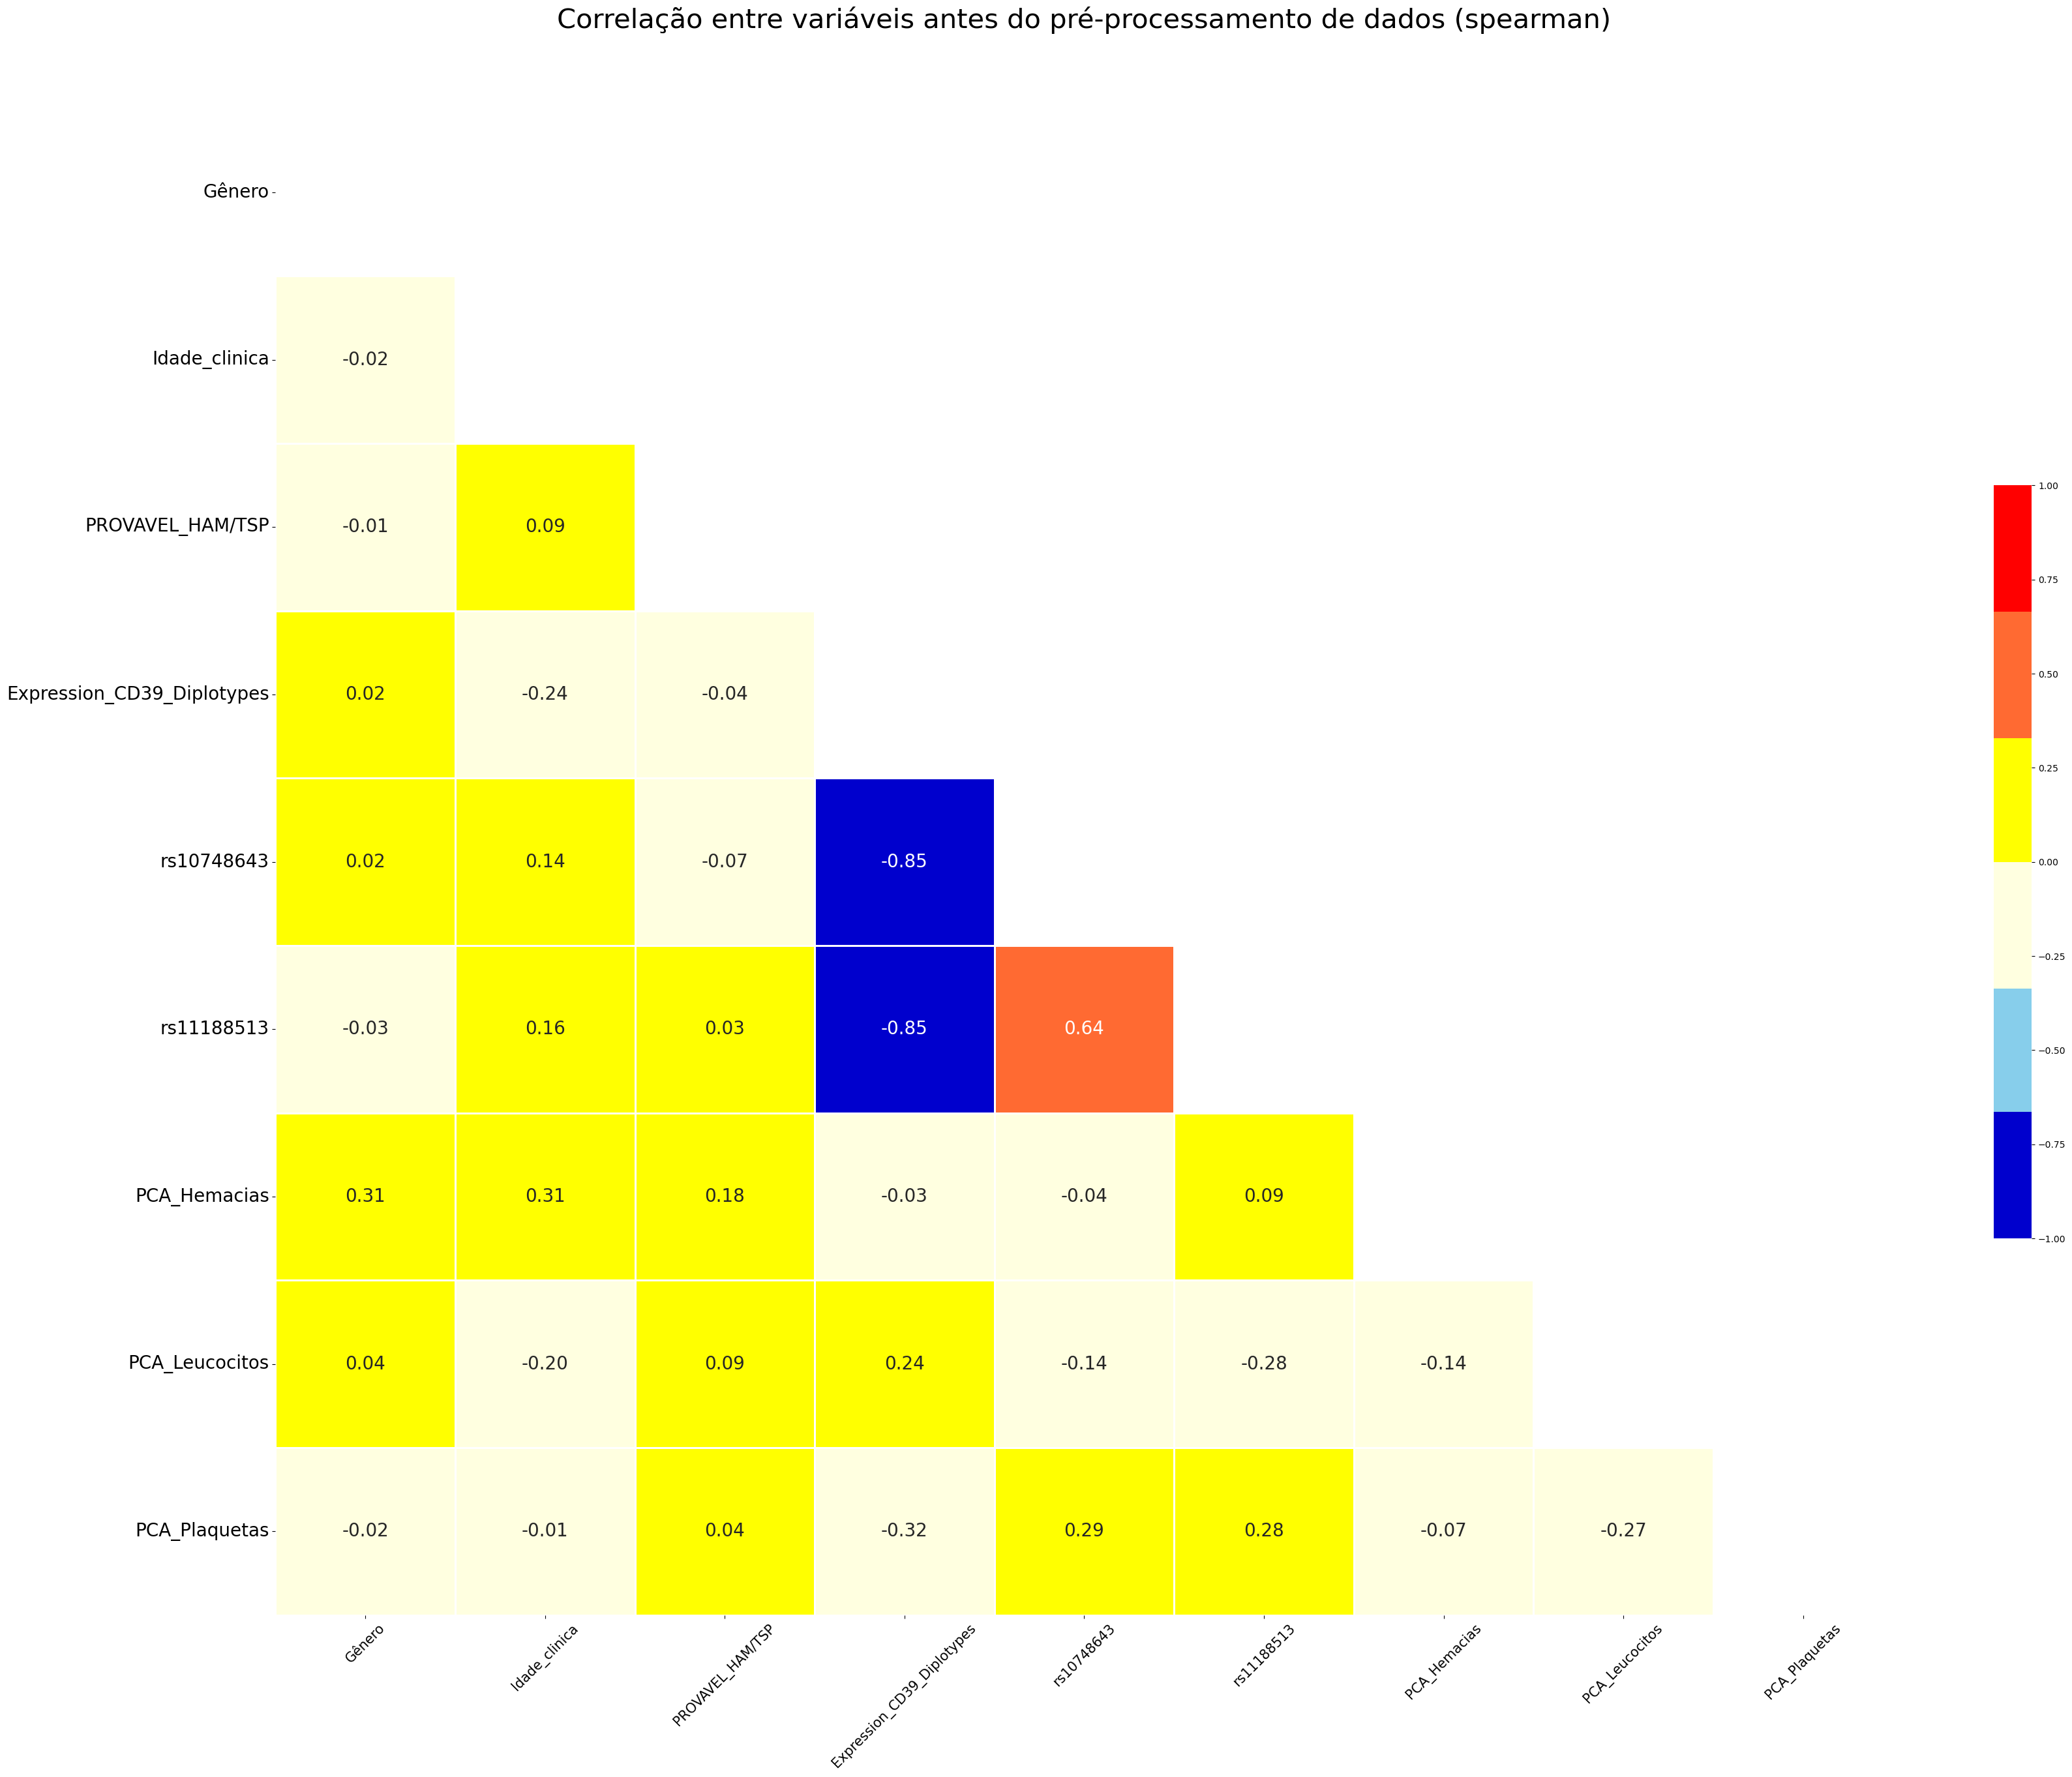

In [26]:
# Correlation
mypal= ['#0000CD', '#87CEEB', '#FFFFE0','#FFFF00', '#ff6a32','#FF0000']
metodo_correlacao = "spearman"
df_ = df

corr = df_.corr(method= metodo_correlacao)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(40, 30), facecolor=None)
cmap = sns.color_palette(mypal, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0, annot=True,
            square=False, linewidths=1, cbar_kws={"shrink": 0.5}, fmt='.2f', annot_kws={"size": 20})
plt.yticks(rotation=0, fontsize=20)
plt.xticks(rotation=45, fontsize=15)
ax.set_title("Correlação entre variáveis antes do pré-processamento de dados ("+metodo_correlacao+")", fontsize=30, y= 1.05)


# Save the graphic in PDF
plt.savefig('../exploratory_analysis/' + 'initial_df_plot_heatmap_corr_pearson.pdf')

plt.show()

In [34]:
# Count the total number of patients with HAM/TSP in relation to DataFrame 'y'
pacientes_com_HAM_feminino = ((df['Gênero'] == 1) & (df['PROVAVEL_HAM/TSP'] == 1)).sum()
print(f'Pacientes do sexo Feminino com comprometimento neurológico: {pacientes_com_HAM_feminino}')

# Count the total number of female patients without HAM/TSP
pacientes_sem_HAM_feminino = ((df['Gênero'] == 1) & (df['PROVAVEL_HAM/TSP'] == 0)).sum()
print(f'Pacientes do sexo Feminino sem comprometimento neurológico: {pacientes_sem_HAM_feminino}')

# Count the total number of male patients without HAM/TSP
pacientes_sem_HAM_masculino = ((df['Gênero'] == 0) & (df['PROVAVEL_HAM/TSP'] == 0)).sum()
print(f'Pacientes do sexo Masculino sem comprometimento neurológico: {pacientes_sem_HAM_masculino}')

# Count the total number of male patients without HAM/TSP
pacientes_com_HAM_masculino = ((df['Gênero'] == 0) & (df['PROVAVEL_HAM/TSP'] == 1)).sum()
print(f'Pacientes do sexo Masculino com comprometimento neurológico: {pacientes_com_HAM_masculino}')


Pacientes do sexo Feminino com comprometimento neurológico: 15
Pacientes do sexo Feminino sem comprometimento neurológico: 44
Pacientes do sexo Masculino sem comprometimento neurológico: 22
Pacientes do sexo Masculino com comprometimento neurológico: 8


**Linear regression**

In [36]:
y = df['PROVAVEL_HAM/TSP']  # Target variable
X = df.drop('PROVAVEL_HAM/TSP', axis=1)  # Predictor variables

# Add a constant to DataFrame X to adjust the intercept in the model
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Obtain the p-values for each independent variable
p_values = model.pvalues

# Defining the destination directory and file name
destination_dir = '../exploratory_analysis/'
output_file = os.path.join(destination_dir, 'Linear_Regression_Exploratory_Analysis.txt')

# Save the p-values
with open(output_file, 'w') as f:
    f.write("P-values for each independent variable:\n")
    f.write(str(p_values))

print(p_values)
print(f"Os p-values foram salvos em {output_file}.")


const                         0.117908
Gênero                        0.320130
Idade_clinica                 0.883880
Expression_CD39_Diplotypes    0.804567
PCA_Hemacias                  0.012544
PCA_Leucocitos                0.147590
PCA_Plaquetas                 0.298003
dtype: float64
Os p-values foram salvos em ../exploratory_analysis/Linear_Regression_Exploratory_Analysis.txt.


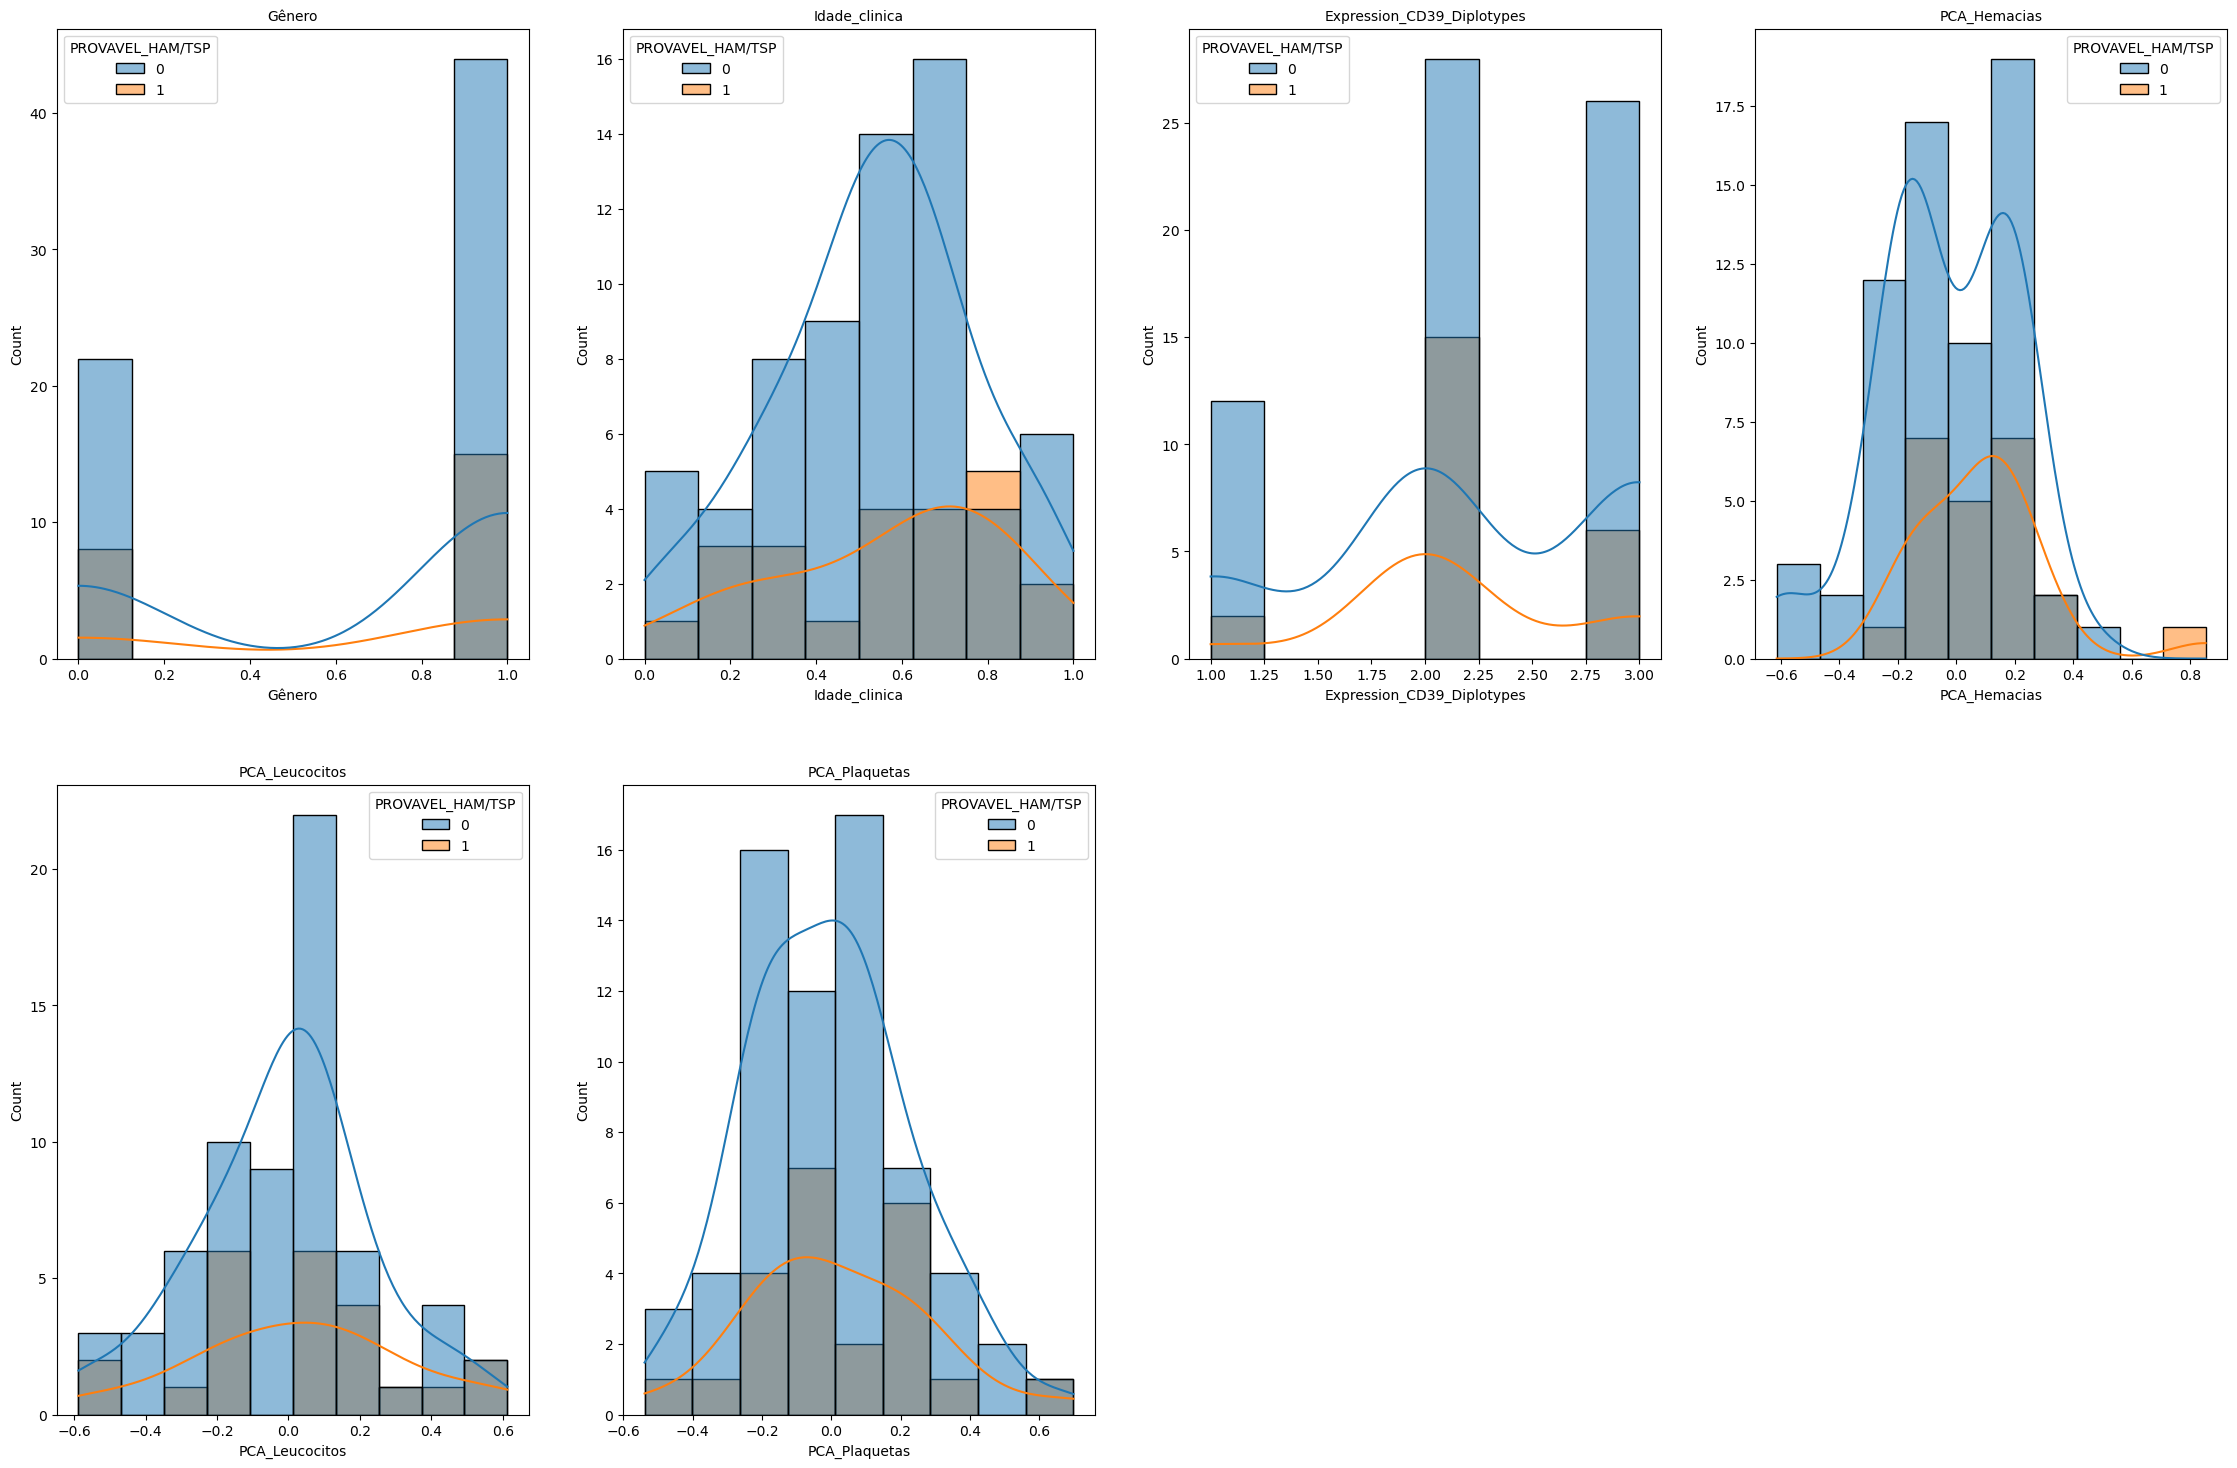

In [37]:
# Define the target variable
target_column = 'PROVAVEL_HAM/TSP'

# Taking all columns from the DataFrame, except the target column
column_names = [col for col in df.columns if col != target_column]

# Visualization of the distributions of each feature
plt.figure(figsize=(28, 18))

# Adjusting the number of columns for visualization
n_cols = 4
n_rows = len(column_names) // n_cols + (len(column_names) % n_cols > 0)

# Loop to create a histogram for each column
for i, feature in enumerate(column_names):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(data=df, x=feature, hue=target_column, kde=True)
    plt.title(f'{feature}', fontsize = 10)
    
# Save the graphic in PDF
plt.savefig('../exploratory_analysis/' + 'Classes_distribution_variables.pdf')

plt.show()


**T-student**
- Evaluation of the relationship between the independent variables and the target outcome


In [38]:
# List to store the characteristics that pass the t-test and their p-values
selected_features_ttest = []

# Define the characteristics (excluding the 'HAM/TSP' class column)
features = [col for col in df.columns if col != 'PROVAVEL_HAM/TSP']

# Iterate through the characteristic columns
for feature in features:
    # Extract data for each class
    class_0 = df.loc[df['PROVAVEL_HAM/TSP'] == 0, feature]
    class_1 = df.loc[df['PROVAVEL_HAM/TSP'] == 1, feature]

    # Perform the t-test
    _, p_value = ttest_ind(class_0, class_1)

    # If the p-value is less than a threshold (e.g. 0.05), consider the characteristic significant
    if p_value < 0.05:
        selected_features_ttest.append((feature, p_value))

# DataFrame with only the characteristics selected by the t-test
selected_features_names = [feature for feature, p_value in selected_features_ttest]
df_selected = df[selected_features_names]

# Target directory
destination_dir = '../exploratory_analysis/'
output_file = os.path.join(destination_dir, 'T-student_exploratory_Analysis.txt')

# Salvando o arquivo diretamente na pasta de destino
print(f'Out of {len(features)} features, {len(selected_features_ttest)} were selected by the t-test: ')
with open(output_file, 'w') as arquivo:
    for feature, p_value in selected_features_ttest:
        print(f'- {feature} (p-value: {p_value:.5f})', file=arquivo)



Out of 6 features, 1 were selected by the t-test: 


# **Feature selection**

**Definition of variables and models**

In [4]:
classifiers = {
    "DT": DecisionTreeClassifier(random_state=42),
    "GB": GradientBoostingClassifier(random_state=42),
    "LR": LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42),
    "MLP": MLPClassifier(random_state=42),
    "NB": GaussianNB(),
    "RF": RandomForestClassifier(random_state=42),
    "SVM": SVC(kernel='linear', random_state=42, probability=True),
    "KNN": KNeighborsClassifier(2),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "LSVM": LinearDiscriminantAnalysis()
}

# List of model names that have been adjusted
model_name = ['DT', 'GB', 'LR', 'MLP', 'NB', 'RF', 'SVM', 'KNN', 'AdaBoost', 'LSVM']


y = df['PROVAVEL_HAM/TSP']  # Target variable
X = df.drop('PROVAVEL_HAM/TSP', axis=1)  # Predictor variables

**Calling functions**


K-best function

In [5]:
def feature_selection_and_evaluation(X_resampled, y_resampled, classifiers, model_name, destination_dir):

    # Initialize list to store all results
    all_results = []

    # Initialize dictionary to store selected characteristics for each value of k
    selected_features_dict = {}

    # Test different values of “k” for SelectKBest
    for k in range(1, X_resampled.shape[1] + 1):
        # Select the best “k” characteristics
        selector = SelectKBest(score_func=f_classif, k=k)
        X_train_selected = selector.fit_transform(X_resampled, y_resampled)
        selected_features = X_resampled.columns[selector.get_support()]

        # Store the selected characteristics in the dictionary
        selected_features_dict[k] = selected_features.tolist()

        # Initialize list to store the results of each classifier
        resultados = []

        # Iterate over the classifiers
        for nome in model_name:
            item = classifiers[nome]  # Get the classifier by name
            # Train the model
            item.fit(X_train_selected, y_resampled)

            # Making predictions
            y_pred = item.predict(X_train_selected)

            # Calculate the confusion matrix
            tn, fp, fn, tp = confusion_matrix(y_resampled, y_pred).ravel()

            # Calculate sensitivity and specificity
            sensitivity = tp / (tp + fn)
            specificity = tn / (tn + fp)

            # Calculate G-mean
            g_mean = np.sqrt(sensitivity * specificity)

            resultados.append((nome, g_mean))

        # Store the results for the value of k
        all_results.append((k, resultados))

    # Create a DataFrame to store the results
    df_results = pd.DataFrame(columns=["k"] + model_name)

    # Add the results to the DataFrame
    for k, resultados in all_results:
        g_means = [g_mean for _, g_mean in resultados]
        df_results.loc[k] = [k] + g_means

    # Calculate the average G-mean for each value of k
    df_results["G-mean"] = df_results.iloc[:, 1:].mean(axis=1)

    # Select the five lines with the highest averages
    top_5_mean = df_results.nlargest(5, "G-mean")

    # Create an Excel file
    wb = Workbook()

    # Add the first tab with the results
    ws1 = wb.active
    ws1.title = "Resultados"

    # Add the results to Excel
    for r in dataframe_to_rows(df_results, index=True, header=True):
        ws1.append(r)

    # Create the second tab for the five rows with the highest averages
    ws2 = wb.create_sheet(title="Top 5 Médias")

    # Add the results to Excel for top 5 mean
    for r in dataframe_to_rows(top_5_mean, index=True, header=True):
        ws2.append(r)

    # Create a new tab for selected characteristics for each k
    ws_features = wb.create_sheet(title="Selected Features")

    # Add the headers for the selected characteristics
    headers = ["k"] + [f"Feature_{i}" for i in range(1, X_resampled.shape[1] + 1)]
    ws_features.append(headers)

    # Add the selected characteristics for each k to the Excel file
    for k, features in selected_features_dict.items():
        row_data = [k] + features
        ws_features.append(row_data)

    # Set the file name and destination directory
    feature_selection = f"resultados_feature_selection.xlsx"
    output_file = os.path.join(destination_dir, feature_selection)

    # Save the Excel file in the destination directory
    wb.save(output_file)

    # Return the path of the saved file
    return output_file


Evaluation of multicollinearity (VIF) function

In [6]:
def calculate_vif(X, caminho_arquivo):
    # Adds a column of constants to the DataFrame
    df_with_const = add_constant(pd.DataFrame(X, columns=X.columns))

    # List for storing VIF results
    vif_data = []

    # Function to calculate the VIF in relation to the 'HAM/TSP' column
    def calculate_vif(column_index):
        return variance_inflation_factor(df_with_const.values, column_index)

    # Calculate the VIF for each variable in relation to the 'HAM/TSP' column
    for i, column in enumerate(df_with_const.columns):
        if column != 'const' and column != 'HAM/TSP':
            vif = calculate_vif(i)
            vif_data.append((column, vif))

    # Convert the results into a DataFrame
    vif_df = pd.DataFrame(vif_data, columns=["Variable", "VIF"])

    # Save the DataFrame in an Excel file
    vif_df.to_excel(destination_dir, index=False)

destination_dir = '../exploratory_analysis/VIF_data.xlsx'
calculate_vif(X, destination_dir)


Applying VIF and K-Best functions to different methods of imbalance management without cross-validation
- Oversampling methods are biased towards over-optimistic assessments


In [7]:
# Global variables
selected_balance_method = None  
balance_method = {}  

# Dictionary to map methods to their acronyms
method_siglas = {
    'RandomOverSampler': 'ROS',
    'SMOTENC': 'SMTNC',
    'RandomUnderSampler': 'RUS',
    "Tomek's links": 'TL'
}

# Function to calculate VIF
def calculate_vif(X, destination_dir):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # Saving the result in an Excel file
    os.makedirs(destination_dir, exist_ok=True)
    vif_data.to_excel(os.path.join(destination_dir, 'vif_values.xlsx'), index=False)

# Function to apply balancing
def balance_data(method):
    global df, X, y, selected_balance_method, balance_method  
    selected_balance_method = method  
    scaler = MinMaxScaler()
    destination_dir = f'../exploratory_analysis/'

    # Checking if the DataFrame is empty
    if df.empty:
        return "Load data first!"

    # Updating the global dictionary with the method acronym
    balance_method['selected'] = method_siglas.get(method, 'N/A')

    # Defining X and y from the DataFrame
    if method == 'RandomOverSampler':
        sampler = RandomOverSampler(random_state=42)
        X_resampled, y_resampled = sampler.fit_resample(X, y)

    elif method == 'SMOTENC':
        # Identifying the categorical columns in X
        categorical_columns = [col for col in X.columns if col != 'Idade_clinica']
        
        # Checking for categorical columns
        if not categorical_columns:
            return "Error: SMOTENC requires at least one categorical feature in X."

        # Selecting the categorical columns, excluding “Clinical_age”
        categorical_features = [X.columns.get_loc(col) for col in categorical_columns]
        sampler = SMOTENC(categorical_features=categorical_features, random_state=42)
        X_resampled, y_resampled = sampler.fit_resample(X, y)

    elif method == 'RandomUnderSampler':
        sampler = RandomUnderSampler(random_state=42)
        X_resampled, y_resampled = sampler.fit_resample(X, y)

    elif method == "Tomek's links":
        sampler = TomekLinks()
        X_resampled, y_resampled = sampler.fit_resample(X, y)

    else:
        return "Invalid method!"

    # Scaling the “Age_clinic” column
    X_resampled['Idade_clinica'] = scaler.fit_transform(X_resampled[['Idade_clinica']])

    # Calling up evaluation functions
    output_file = feature_selection_and_evaluation(X_resampled, y_resampled, classifiers, model_name, destination_dir)
    calculate_vif(X_resampled, destination_dir)

    return f"Data balanced using {method}! New shape: {X_resampled.shape}"

# Selecting the balancing method
balance_options = ['RandomOverSampler', 'SMOTENC', 'RandomUnderSampler', "Tomek's links"]
balance_selector = widgets.Dropdown(
    options=balance_options,
    description='Balance Method:'
)

# Interactive function for loading and processing the selected balancing method
@widgets.interact(balance_method=balance_selector)
def load_and_process_selected_method(balance_method):
    result = balance_data(balance_method)
    print(result)  # Exibir o resultado da função balance_data

# Function to access the global variable with the selected balancing method and its acronym
def get_selected_balance_method():
    global selected_balance_method, balance_method  

# Accessing the balancing method in another cell
get_selected_balance_method()

interactive(children=(Dropdown(description='Balance Method:', options=('RandomOverSampler', 'SMOTENC', 'Random…

## Data manipulation to create new categorizations

PCA_hemacias

In [9]:
# Select the columns of interest
columns_of_interest = ['HEMATÓCRITO (%)', 'VCM (fL)', 'HCM (pg)', 'CHCM (g/dL)', 'HEMÁCIAS (x10^6μl)', 'HEMOGLOBINA (g/dL)']
X = df[columns_of_interest]

# Apply PCA
pca = PCA(n_components=1)  # Número de componentes principais a serem extraídos
principal_component = pca.fit_transform(X)

# Add PCA to the dataframe
df['PCA_Hemacias'] = principal_component

# Remove the original columns of interest
df = df.drop(columns=columns_of_interest)

# Display the DataFrame columns to check the result
print(df.columns) 


KeyError: "None of [Index(['HEMATÓCRITO (%)', 'VCM (fL)', 'HCM (pg)', 'CHCM (g/dL)',\n       'HEMÁCIAS (x10^6μl)', 'HEMOGLOBINA (g/dL)'],\n      dtype='object')] are in the [columns]"

PCA_Leucocitos

In [20]:
# Select the columns of interest
columns_of_interest = ['Leucócitos', 'Segmentados (neutrofilos)', 'Linfocitos Tipicos']
X = df[columns_of_interest]

# Apply PCA
pca = PCA(n_components=1)  
principal_component = pca.fit_transform(X)

# Add PCA to the dataframe
df['PCA_Leucocitos'] = principal_component

# Remove the original columns of interest
df = df.drop(columns=['Leucócitos', 'Segmentados (neutrofilos)', 'Eosinófilos',
       'Basófilos', 'Linfocitos Tipicos', 'Monócitos'])

# Display the DataFrame columns to check the result
print(df.columns)


Index(['Gênero', 'Idade_clinica', 'PROVAVEL_HAM/TSP', 'rs10748643',
       'rs11188513', 'MPV (fL)', 'Plaquetas (x10^3 μl)', 'PCA_Hemacias',
       'PCA_Leucocitos'],
      dtype='object')


In [21]:
# Select the columns of interest
columns_of_interest = ['MPV (fL)', 'Plaquetas (x10^3 μl)']
X = df[columns_of_interest]

# Apply PCA
pca = PCA(n_components=1)  
principal_component = pca.fit_transform(X)

# Add PCA to the dataframe
df['PCA_Plaquetas'] = principal_component

# Remove the original columns of interest
df = df.drop(columns=columns_of_interest)

# Display the DataFrame columns to check the result
print(df.columns)  


Index(['Gênero', 'Idade_clinica', 'PROVAVEL_HAM/TSP', 'rs10748643',
       'rs11188513', 'PCA_Hemacias', 'PCA_Leucocitos', 'PCA_Plaquetas'],
      dtype='object')


In [8]:
print(df.columns)

Index(['Gênero', 'Idade_clinica', 'PROVAVEL_HAM/TSP',
       'Expression_CD39_Diplotypes', 'PCA_Hemacias', 'PCA_Leucocitos',
       'PCA_Plaquetas'],
      dtype='object')


In [43]:
print(df.columns)

Index(['Gênero', 'Idade_clinica', 'PROVAVEL_HAM/TSP',
       'Expression_CD39_Diplotypes', 'PCA_Hemacias', 'PCA_Leucocitos',
       'PCA_Plaquetas'],
      dtype='object')


**Save working dataset**

In [10]:
# Selecting only the desired columns for X
selected_columns = ['Gênero', 'Idade_clinica', 'Expression_CD39_Diplotypes', 'PCA_Hemacias', 'PCA_Leucocitos', 'PCA_Plaquetas']

# Updating X to contain only the selected columns
X = X[selected_columns]

# Combining X and y in a single DataFrame
df_combined = pd.concat([X, y], axis=1)

# Replacing spaces in the dataset name with underscores
dataset_name_cleaned = dataset_name.replace(' ', '_')

# Accessing the balancing method in another cell
sigla_method = balance_method.get('selected', 'N/A')

# Defining the path to save the file, using the name of the modified dataset and the acronym of the method
df_combined_path = f'../datasets/feature_selection/df_{dataset_name_cleaned}_{sigla_method}.csv'

# Saving the combined DataFrame in a CSV file
df_combined.to_csv(df_combined_path, index=False)

print(f'O DataFrame combinado foi salvo em: {df_combined_path}')

# Displaying the first lines of the combined DataFrame
df_combined.head()

# Function to access the name of the dataset loaded in another cell
def get_loaded_dataset_name():
    global dataset_name
    if dataset_name:
        print(f"O dataset salvo com o feature selection é: {dataset_name_cleaned}")
    else:
        print("Nenhum dataset foi carregado ainda.")

# Function to access the balancing method selected in another cell
def get_selected_balance_method():
    global balance_method  
    if 'selected' in balance_method:
        print(f"O método de balanceamento selecionado é: {balance_method['selected']}")
    else:
        print("Nenhum método de balanceamento foi selecionado ainda.")


O DataFrame combinado foi salvo em: ../datasets/feature_selection/df_Hemogram_data_cat_2_SMTNC.csv
